In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import math
from phik import phik_matrix
from scipy.stats import chi2_contingency
import scipy.stats as stats

In [4]:
from sklearn.model_selection import train_test_split, GroupKFold
from feature_engine.imputation import CategoricalImputer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import RareLabelEncoder
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder
from feature_engine.discretisation import ArbitraryDiscretiser
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer, MinMaxScaler
from feature_engine.transformation import BoxCoxTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [5]:
from feature_engine.encoding import MeanEncoder
from feature_engine.encoding import OrdinalEncoder

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.transformation import YeoJohnsonTransformer

In [7]:
# Load the dataset from the CSV file
raw_data = pd.read_csv("appointments.csv")

El conjunto de datos que has proporcionado parece estar relacionado con citas médicas de una compañía de seguros de salud. Aquí hay un resumen inicial de la estructura de los datos:

- **PatientId**: Identificador único para cada paciente (formato numérico grande).
- **AppointmentID**: Identificador único para cada cita.
- **Gender**: Género del paciente (F para femenino, M para masculino).
- **ScheduledDay**: Fecha y hora en que se programó la cita.
- **AppointmentDay**: Fecha de la cita.
- **Age**: Edad del paciente.
- **Neighbourhood**: Vecindario donde se atiende al paciente.
- **Scholarship**: Indica si el paciente está en un programa de ayuda social (0 = No, 1 = Sí).
- **Hipertension**: Indica si el paciente tiene hipertensión (0 = No, 1 = Sí).
- **Diabetes**: Indica si el paciente tiene diabetes (0 = No, 1 = Sí).
- **Alcoholism**: Indica si el paciente tiene problemas con el alcohol (0 = No, 1 = Sí).
- **Handcap**: Número que indica el nivel de discapacidad del paciente.
- **SMS_received**: Indica si el paciente recibió un SMS recordatorio de la cita (0 = No, 1 = Sí).
- **No-show**: Indica si el paciente no asistió a la cita (No = asistió)

In [9]:
raw_data.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [10]:
raw_data.shape

(110527, 14)

In [11]:
# Estadísticas descriptivas de las columnas numéricas
raw_data.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [12]:
raw_data.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

In [13]:
df = raw_data.copy()

In [14]:
cat_cols = df.select_dtypes(include=['category','object']).columns
num_cols = df.select_dtypes(include=['int', 'float']).columns

In [15]:
print(cat_cols)

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood', 'No-show'], dtype='object')


In [16]:
unique_values = {col: df[col].nunique() for col in cat_cols}
print(unique_values)

{'Gender': 2, 'ScheduledDay': 103549, 'AppointmentDay': 27, 'Neighbourhood': 81, 'No-show': 2}


In [17]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 3]

<Figure size 500x300 with 0 Axes>

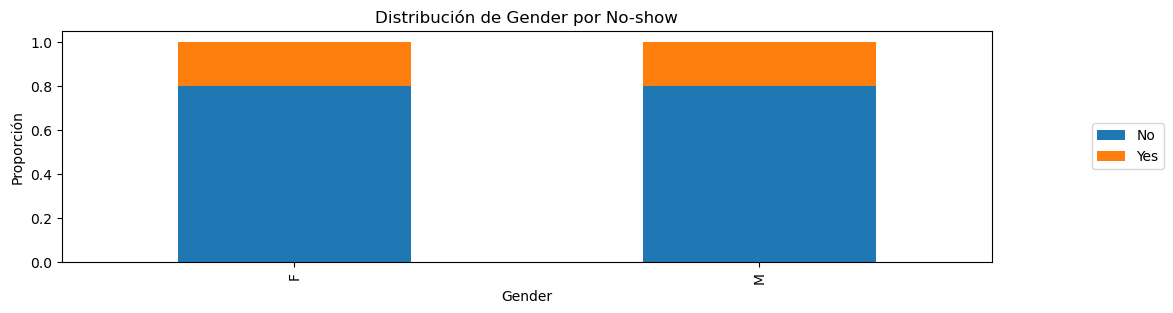

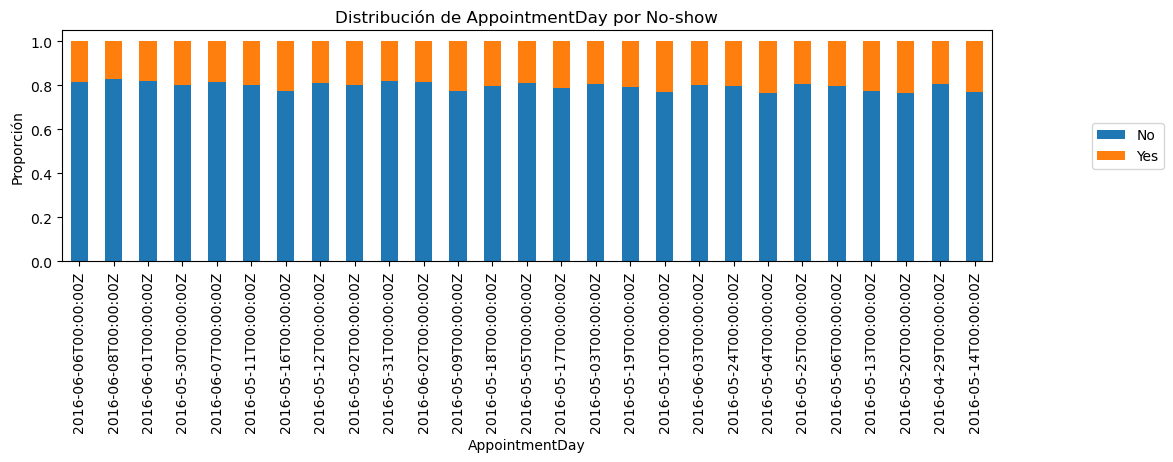

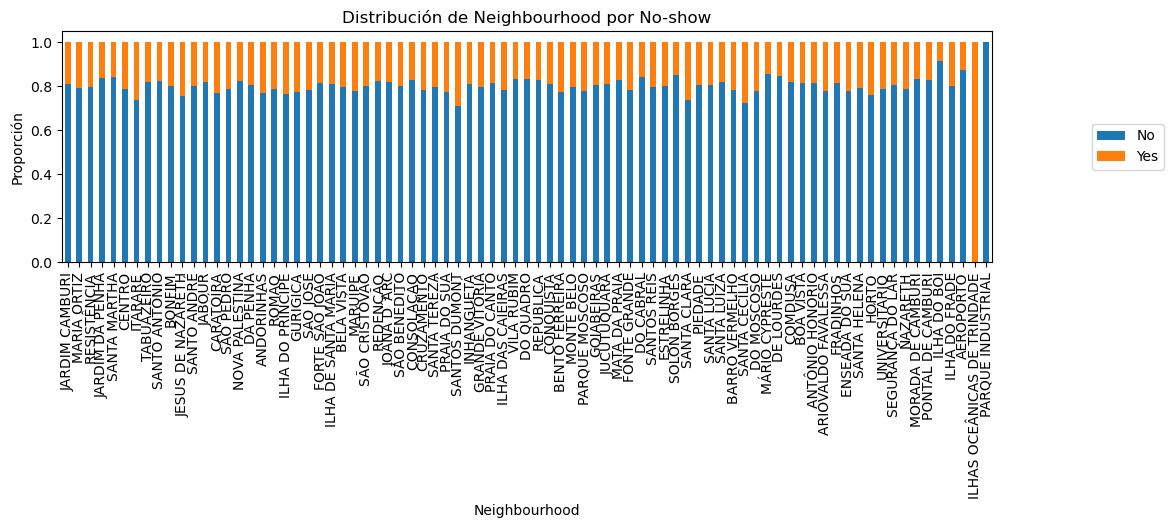

In [18]:
plt.figure(figsize=(5, 3))
for var in cat_cols:
    if (var != 'No-show' and var != 'ScheduledDay'):
        # Crear una tabla de frecuencias absolutas
        freq_table = pd.crosstab(df[var], df["No-show"])
        
        # Calcular la frecuencia máxima para ordenar
        freq_table['Max'] = freq_table.max(axis=1)
        
        # Ordenar las categorías por la frecuencia máxima de cada clase 
        freq_table = freq_table.sort_values(by='Max', ascending=False)

        # Graficar la tabla de frecuencias normalizadas
        freq_table[['No', 'Yes']].div(freq_table[['No', 'Yes']].sum(axis=1), axis=0).plot(kind="bar", stacked=True)
        
        plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left')
        plt.title(f'Distribución de {var} por No-show')
        plt.xlabel(var)  
        plt.ylabel('Proporción') 
        plt.show()

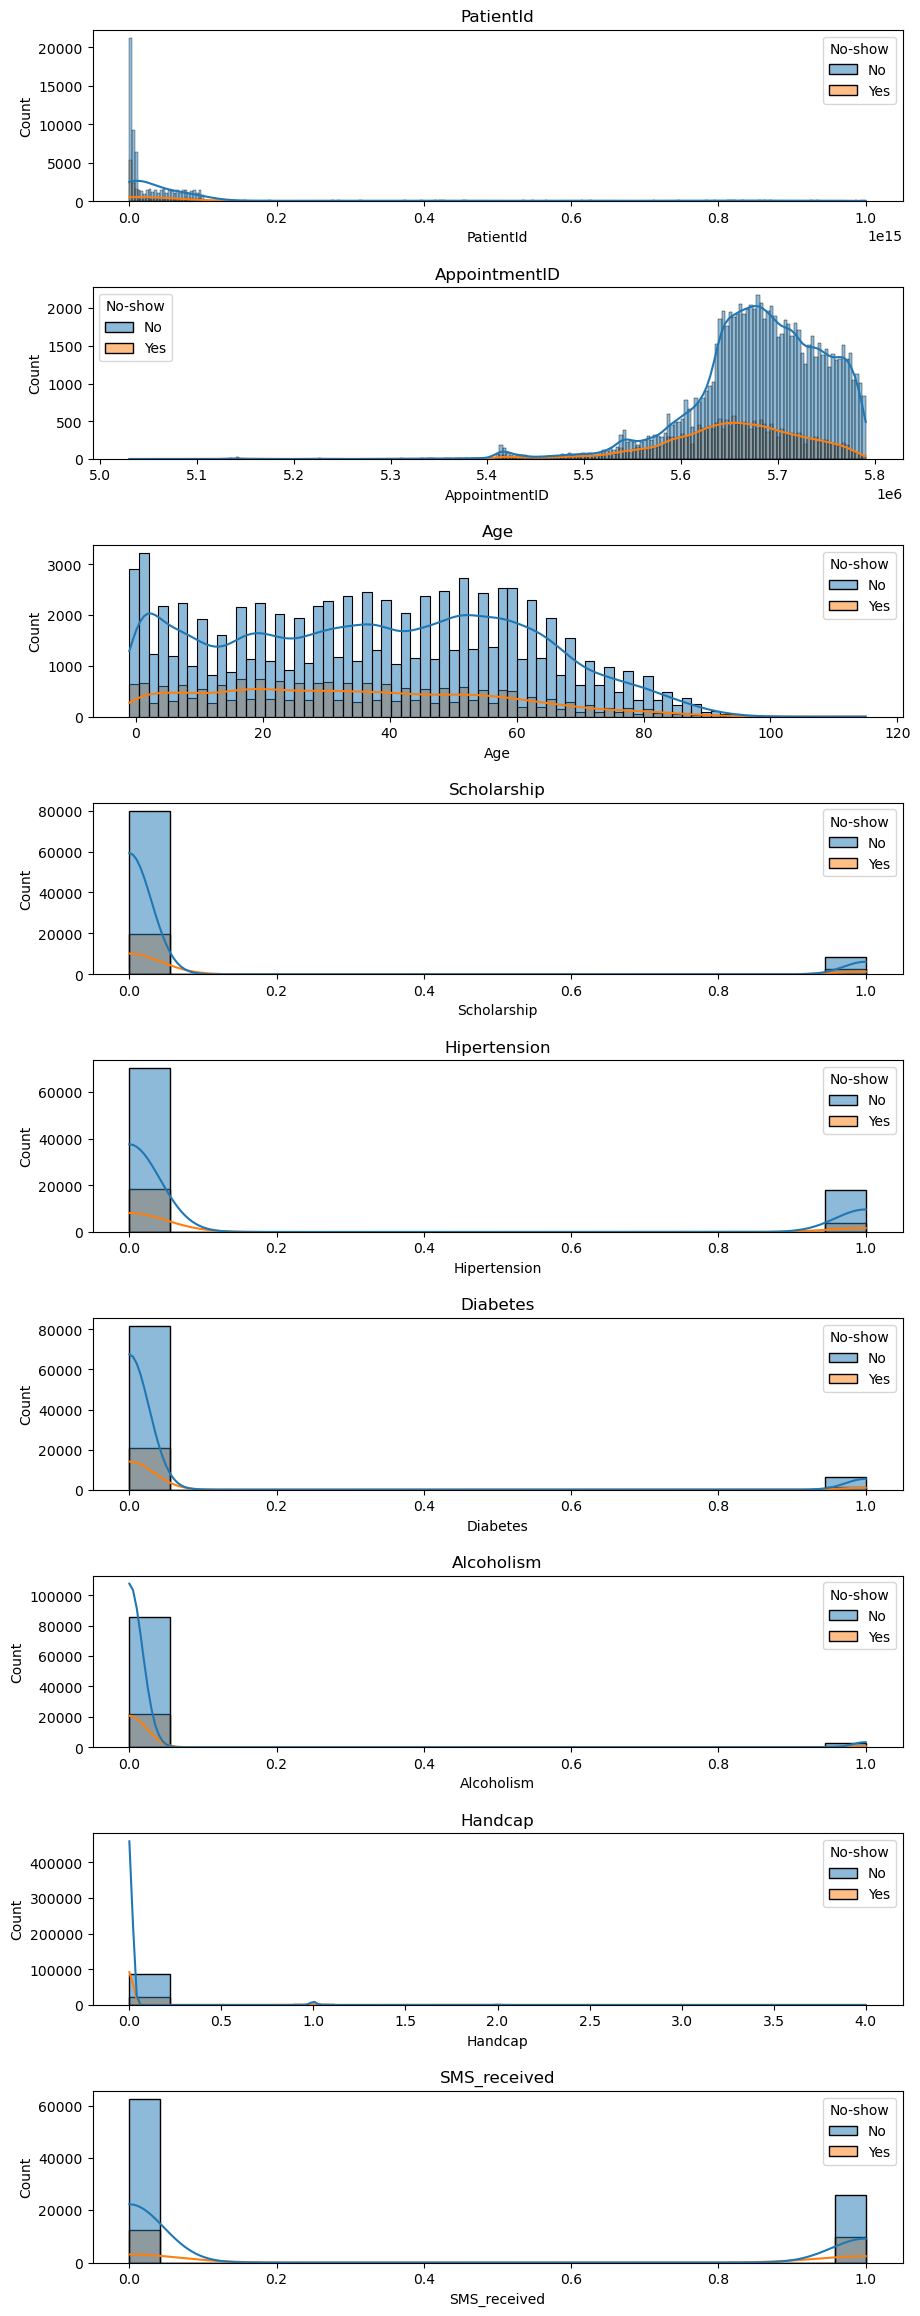

In [19]:
num_vars = len(num_cols)
num_cols_subplot = 1  # Usar una columna
num_rows_subplot = math.ceil(num_vars / num_cols_subplot)

# Aumentar el tamaño total de la figura
plt.figure(figsize=(12, 5 + (num_rows_subplot - 1) * 3))  # Ajusta el multiplicador según sea necesario

for i, var in enumerate(num_cols):
    plt.subplot(num_rows_subplot, num_cols_subplot, i + 1)
    sns.histplot(data=df, x=var, stat="count", kde=True, hue='No-show')
    plt.title(var)  # Añadir título a cada subplot


# Ajustar espacio entre filas
plt.subplots_adjust(hspace=0.5, right=0.8)  # Dejar espacio a la derecha para la leyenda

plt.show()

interval columns not set, guessing: ['PatientId', 'AppointmentID', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']


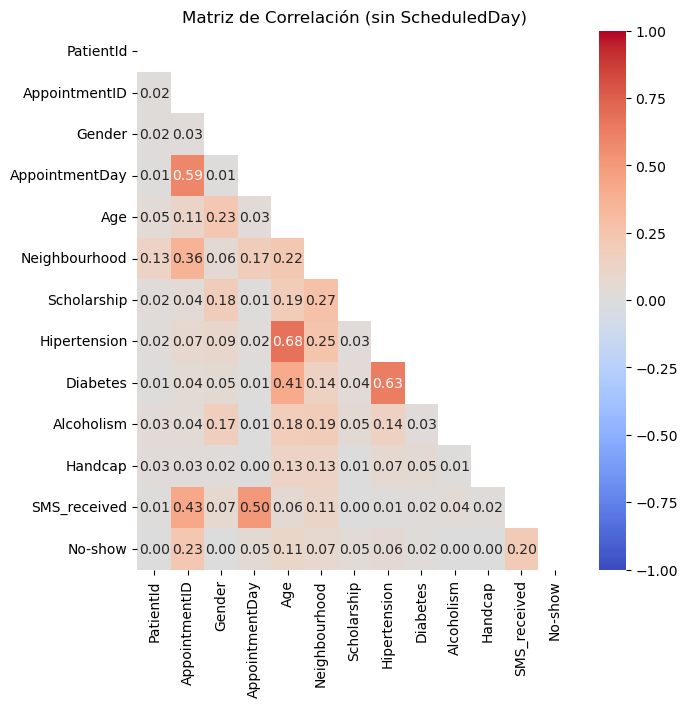

In [20]:
# Calcular la matriz de correlación usando phik, excluyendo 'ScheduledDay'
corr_matrix = df.drop(columns=['ScheduledDay']).phik_matrix()

# Crear una máscara para el triángulo superior
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Graficar la matriz de correlación
plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, vmin=-1, vmax=1)
plt.title('Matriz de Correlación (sin ScheduledDay)')
plt.show()

### Separo el conjunto de datos en los conjuntos de entrenamiento y prueba

#### Como en el conjunto de datos las personas pueden sacar más de un turno es conveniente que todos los registros de una persona se encuentren o en el conjunto de entrenamiento o en el de prueba

In [23]:
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [24]:
df = df.sample(frac=1, random_state=42)

In [25]:
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
84674,2.759575e+13,5756417,F,2016-06-01T08:17:04Z,2016-06-01T00:00:00Z,20,ILHA DAS CAIEIRAS,0,0,0,0,0,0,No
3635,9.673194e+14,5523159,F,2016-03-29T16:09:39Z,2016-05-03T00:00:00Z,37,RESISTÊNCIA,0,0,0,0,0,1,No
16605,3.951641e+12,5693080,F,2016-05-12T17:33:56Z,2016-05-20T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,0,Yes


In [26]:
X = df.drop(columns = "No-show")
y = df.loc[:, ['No-show']]

In [27]:
X.head(4)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
84674,2.759575e+13,5756417,F,2016-06-01T08:17:04Z,2016-06-01T00:00:00Z,20,ILHA DAS CAIEIRAS,0,0,0,0,0,0
3635,9.673194e+14,5523159,F,2016-03-29T16:09:39Z,2016-05-03T00:00:00Z,37,RESISTÊNCIA,0,0,0,0,0,1
16605,3.951641e+12,5693080,F,2016-05-12T17:33:56Z,2016-05-20T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,0
103942,9.173245e+14,5654129,F,2016-05-03T13:54:51Z,2016-06-03T00:00:00Z,24,SANTO ANDRÉ,0,0,0,0,0,1


In [28]:
y.head(4)

,No-show
84674,No
3635,No
16605,Yes
103942,Yes


In [29]:
# Verificar y eliminar filas duplicadas (si las hay)
duplicated_rows = X.duplicated().sum()
print("Filas duplicadas encontradas:", duplicated_rows)

Filas duplicadas encontradas: 0


In [30]:
X.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
dtype: int64

In [31]:
y.isnull().sum()

No-show    0
dtype: int64

In [32]:
groups = df['PatientId']

In [33]:
gkf = GroupKFold(n_splits = 4)

for train_idx, test_idx in gkf.split(X, y, groups=groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [34]:
# X_train, X_test, y_train, y_test = train_test_split( X,y,test_size = 0.2,random_state = 42, stratify=y)

In [35]:
# Comprobar si hay coincidencias de pacientes entre X_train y X_test
common_patients = X_train['PatientId'][X_train['PatientId'].isin(X_test['PatientId'])]
common_patients

Series([], Name: PatientId, dtype: float64)

In [36]:
X_train.shape

(82896, 13)

In [37]:
X_test.shape

(27631, 13)

In [38]:
y_train

,No-show
3635,No
274,No
48969,No
76571,No
6694,No
...,...
76820,No
110268,No
103694,No
860,No


In [39]:
# Calcular el porcentaje de No-show en y_train
porcentaje_no_show_train = (y_train == 'Yes').sum() / len(y_train) * 100
# Acceder al valor escalar
porcentaje_no_show_train = float(porcentaje_no_show_train.iloc[0])
print(f"Porcentaje de No-show en y_train: {porcentaje_no_show_train:.2f}%")

# Calcular el porcentaje de No-show en y_test
porcentaje_no_show_test = (y_test == 'Yes').sum() / len(y_test) * 100
# Acceder al valor escalar
porcentaje_no_show_test = float(porcentaje_no_show_test.iloc[0])
print(f"Porcentaje de No-show en y_test: {porcentaje_no_show_test:.2f}%")

Porcentaje de No-show en y_train: 20.24%
Porcentaje de No-show en y_test: 20.04%


In [40]:
X_train.head(4)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
3635,9.673194e+14,5523159,F,2016-03-29T16:09:39Z,2016-05-03T00:00:00Z,37,RESISTÊNCIA,0,0,0,0,0,1
274,3.995366e+12,5641070,F,2016-04-29T12:16:28Z,2016-04-29T00:00:00Z,41,MARIA ORTIZ,0,0,0,0,0,0
48969,7.988999e+14,5690281,F,2016-05-12T09:48:29Z,2016-05-17T00:00:00Z,68,JARDIM DA PENHA,0,1,0,0,0,0
76571,6.267396e+14,5697447,M,2016-05-13T15:56:43Z,2016-05-13T00:00:00Z,13,ANDORINHAS,1,0,0,0,0,0


In [41]:
y_train.head(4)

,No-show
3635,No
274,No
48969,No
76571,No


In [42]:
X_test.head(4)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
84674,2.759575e+13,5756417,F,2016-06-01T08:17:04Z,2016-06-01T00:00:00Z,20,ILHA DAS CAIEIRAS,0,0,0,0,0,0
16605,3.951641e+12,5693080,F,2016-05-12T17:33:56Z,2016-05-20T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,0
103942,9.173245e+14,5654129,F,2016-05-03T13:54:51Z,2016-06-03T00:00:00Z,24,SANTO ANDRÉ,0,0,0,0,0,1
54876,1.554979e+11,5723075,M,2016-05-20T07:56:23Z,2016-05-20T00:00:00Z,6,ILHA DO PRÍNCIPE,0,0,0,0,1,0


In [43]:
y_test.head(4)

,No-show
84674,No
16605,Yes
103942,Yes
54876,No


### Analisis ingenieria de caracteristicas

#### **PatientId**: Mantener esta caracteristica permite mantener el registro de asistencia de cada cliente, pero en lugar de tratarse como un numero entero se debería tatrar como tipo categorico, la cual tendría una cardinalidad elevada.
#### **AppointmentID**: No tiene poder predictivo, ya que es un codigo que ayuda para la gestion de los turnos utiliza el hospital

In [46]:
# Elimino la caracteristica AppointmentID
drop_feature_AppointmentID = DropFeatures(features_to_drop=['AppointmentID'])
X_train = drop_feature_AppointmentID.fit_transform(X_train)
X_test = drop_feature_AppointmentID.transform(X_test)

In [47]:
# Para el pipeline no es necesario crear una clase 
# ('drop_feature_AppointmentID', DropFeatures(features_to_drop=['AppointmentID'])),

#### **Neighbourhood**: esta caracteristica tiene una alta cardinalidad. Además, algunos de sus valores se pueden observar solo una pocas veces

In [49]:
df_train = X_train.copy()
df_train['No-show'] = y_train

# Crear la tabla de contingencia
contingency_table = pd.crosstab(df_train['Neighbourhood'], df_train['No-show'])

# Añadir fila de totales por barrio
contingency_table.loc['Total'] = contingency_table.sum()

# Añadir columna de totales
contingency_table['Total'] = contingency_table.sum(axis=1)

# Ordenar la tabla por la columna 'Total' de mayor a menor
contingency_table = contingency_table.sort_values(by='Total', ascending=False).drop('Total', axis=0)

# Mostrar la tabla de contingencia
contingency_table

No-show,No,Yes,Total
Neighbourhood,,,
JARDIM CAMBURI,4660,1120,5780
MARIA ORTIZ,3386,907,4293
RESISTÊNCIA,2624,674,3298
JARDIM DA PENHA,2388,483,2871
ITARARÉ,1936,696,2632
...,...,...,...
ILHA DO BOI,21,2,23
ILHA DO FRADE,8,2,10
AEROPORTO,7,1,8


In [50]:
contingency_table['no_show_rate'] = contingency_table['Yes']/contingency_table['Total']
contingency_table.tail(8)

No-show,No,Yes,Total,no_show_rate
Neighbourhood,,,,
SEGURANÇA DO LAR,78,18,96,0.187500
MORADA DE CAMBURI,68,12,80,0.150000
PONTAL DE CAMBURI,51,10,61,0.163934
ILHA DO BOI,21,2,23,0.086957
ILHA DO FRADE,8,2,10,0.200000
AEROPORTO,7,1,8,0.125000
PARQUE INDUSTRIAL,1,0,1,0.000000
ILHAS OCEÂNICAS DE TRINDADE,0,1,1,1.000000


In [51]:
tol_value = 100 / len(df)  # Para el umbral deseado (en cantidad de observaciones) se calcula el porcentaje correspondiente

rare_encoder = RareLabelEncoder(
    tol = tol_value,  # Umbral basado en la cantidad fija
    n_categories = 20,
    variables=[
        "Neighbourhood"
    ],
    replace_with='Other',
)

In [52]:
tol_value

0.0009047563038895474

In [53]:
rare_encoder.fit(X_train)

RareLabelEncoder(n_categories=20, replace_with='Other',
                 tol=0.0009047563038895474, variables=['Neighbourhood'])

In [54]:
X_train_rare_label = rare_encoder.transform(X_train)
X_test_rare_label = rare_encoder.transform(X_test)

In [55]:
# Para el pipe no hace falta crear una clase

In [56]:
df_train = X_train_rare_label.copy()
df_train['No-show'] = y_train

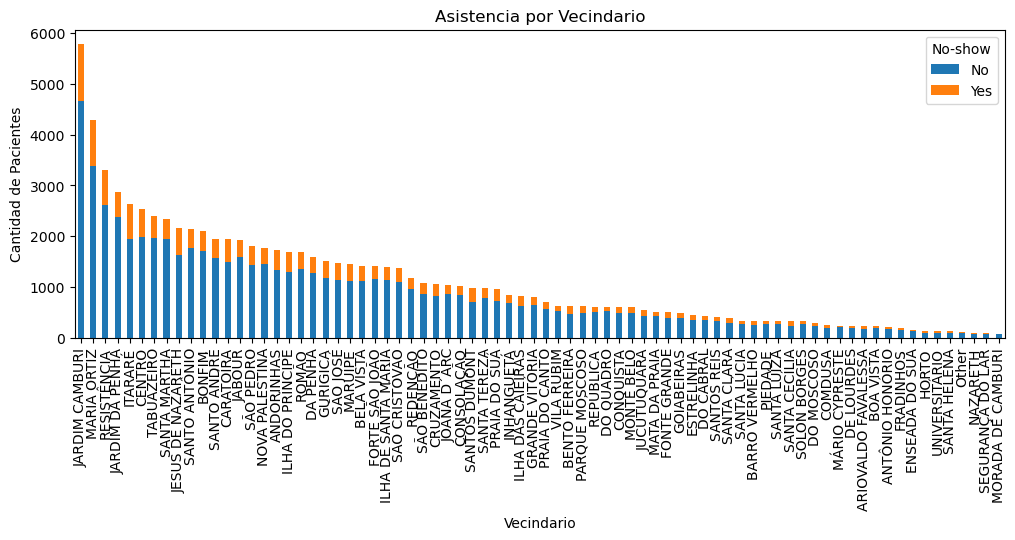

In [57]:
# Contar y apilar
counts = df_train.groupby(['Neighbourhood', 'No-show']).size().unstack(fill_value=0)

# Sumar las filas para obtener totales por vecindario
counts['Total'] = counts.sum(axis=1)

# Ordenar el DataFrame por el total de pacientes en orden decreciente
counts = counts.sort_values(by='Total', ascending=False).drop('Total', axis=1)

# Crear el gráfico de barras apiladas
counts.plot(kind='bar', stacked=True, figsize=(12, 4))

plt.title('Asistencia por Vecindario')
plt.ylabel('Cantidad de Pacientes')
plt.xlabel('Vecindario')
plt.xticks(rotation=90)
plt.show()

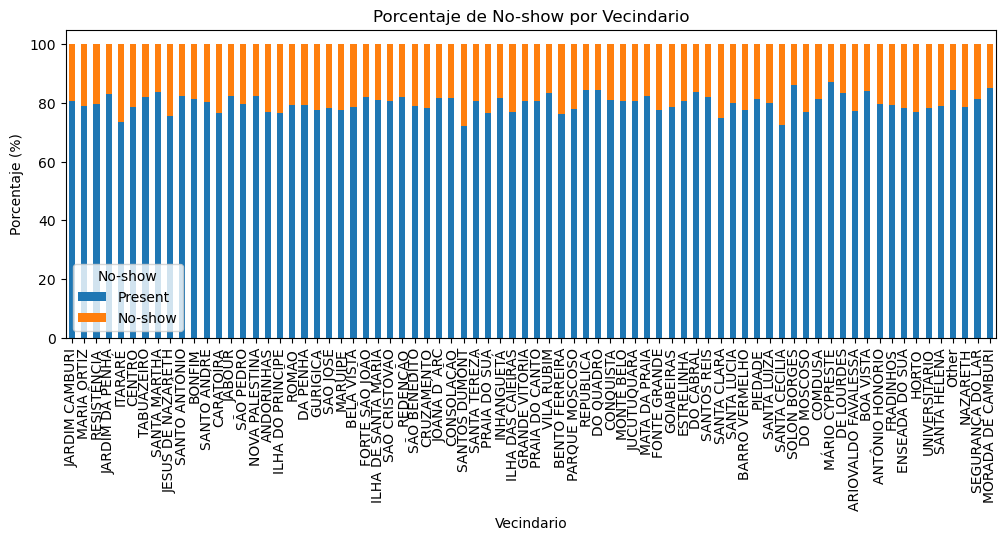

In [58]:
# Contar y apilar
counts = df_train.groupby(['Neighbourhood', 'No-show']).size().unstack(fill_value=0)
# Ordenar el DataFrame por el total de pacientes en orden decreciente
counts['Total'] = counts.sum(axis=1)
counts = counts.sort_values(by='Total', ascending=False).drop('Total', axis=1)

# Calcular el porcentaje de No-show
percentage = counts.div(counts.sum(axis=1), axis=0) * 100  # Convertir a porcentaje

# Sumar las filas para obtener totales por vecindario
percentage['Total'] = percentage.sum(axis=1)
percentage = percentage.drop('Total', axis=1)

# Crear el gráfico de barras apiladas
percentage.plot(kind='bar', stacked=True, figsize=(12, 4))

plt.title('Porcentaje de No-show por Vecindario')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Vecindario')
plt.xticks(rotation=90)
plt.legend(title='No-show', labels=['Present', 'No-show'])
plt.show()

#### Para transformar Neighbourhood de una variable tipo objeto a numérica utilizaremos el metodo de smoothing mean encoding que reemplazará cada una de los nombres de los barrios por la cantidad media correspondiente de veces que los pasientes no se presentaron con el objetivo de crear una relacion monotonica entre esta nueva caracteristica con la variable objetivo. Es smoothing porque al calcular la media tendrá en cuenta un peso que refleje la diferencia entre la media del conjunto de entrenamiento con la media del conjunto de datos total. 

#### Antes de poder hacer lo detallado en la celda anterior debo transformar la variable objetivo en dummies 

In [61]:
y_train.loc[:, 'No-show'] = y_train['No-show'].map({'Yes': 1, 'No': 0})
y_test.loc[:, 'No-show'] = y_test['No-show'].map({'Yes': 1, 'No': 0})

In [62]:
y_train.dtypes

No-show    object
dtype: object

In [63]:
y_train = y_train['No-show'].astype('int')
y_test = y_test['No-show'].astype('int')

#### Ya que, cuando el programa se ponga en productivo la variable objetivo no es dato y por lo tanto se deberá pronosticar, entonces no hace falta incluir esta transformación en el pipeline

In [65]:
mean_enc = MeanEncoder(variables=["Neighbourhood"])

In [66]:
# when fitting the transformer, we need to pass the target as well
mean_enc.fit(X_train_rare_label, y_train)

MeanEncoder(variables=['Neighbourhood'])

In [67]:
X_train_1_enco = mean_enc.transform(X_train_rare_label)
X_test_1_enco = mean_enc.transform(X_test_rare_label)

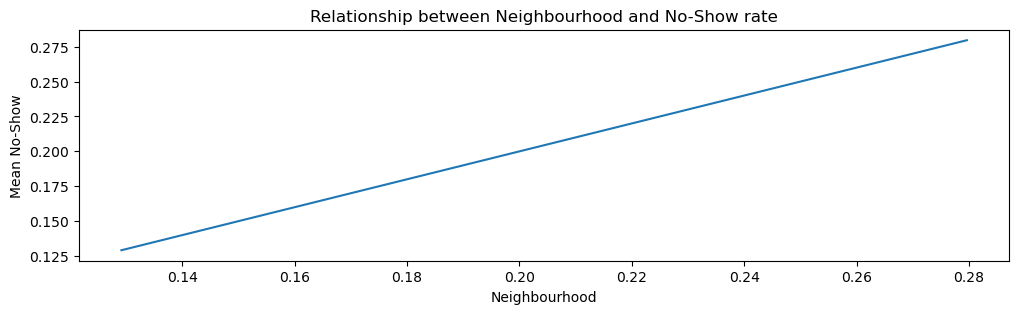

In [68]:
fig = plt.figure()
fig = y_train.groupby(X_train_1_enco["Neighbourhood"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("Neighbourhood"))
fig.set_ylabel("Mean No-Show")
plt.show()

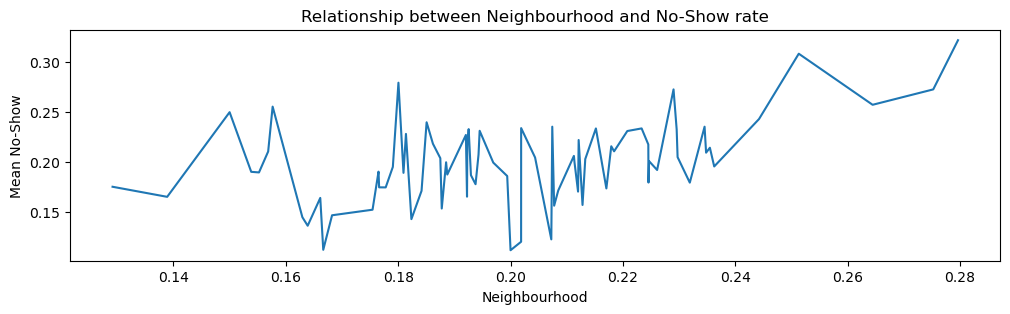

In [69]:
fig = plt.figure()
fig = y_test.groupby(X_test_1_enco["Neighbourhood"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("Neighbourhood"))
fig.set_ylabel("Mean No-Show")
plt.show()

#### Dado que en en los datos de prueba no hay mucho ruido y el patron no es similar a una funcion monotona, esta forma de codificación puede no ser la ideal.
#### Esto puede deberse a la forma en la que se separaron los conjuntos de entrenamiento y test. Puede ser que como los registros de un paciente solo pueden encontrarse en uno de los dos conjuntos la taza de ausencias varie seguen que pacientes se encuentren en que conjunto de datos.

In [71]:
ordinal_enc = OrdinalEncoder(
    # NOTE that we indicate ordered in the encoding_method, otherwise it assings numbers arbitrarily
    encoding_method="ordered",
    variables=["Neighbourhood"],
)

In [72]:
ordinal_enc.fit(X_train_rare_label, y_train)

OrdinalEncoder(variables=['Neighbourhood'])

In [73]:
X_train_2_enco = ordinal_enc.transform(X_train_rare_label)
X_test_2_enco = ordinal_enc.transform(X_test_rare_label)

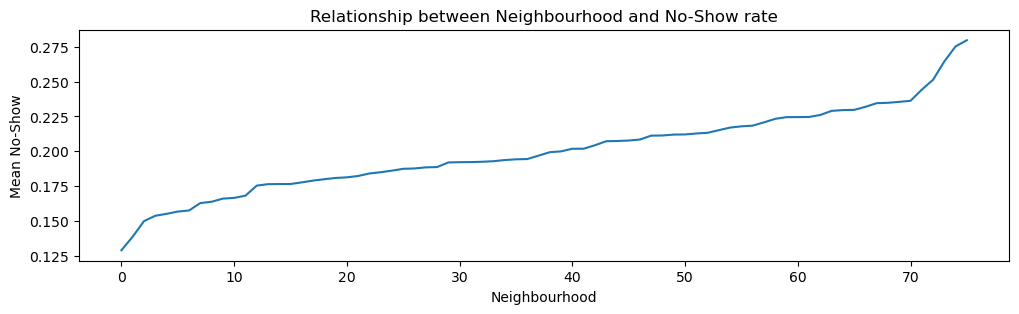

In [74]:
fig = plt.figure()
fig = y_train.groupby(X_train_2_enco["Neighbourhood"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("Neighbourhood"))
fig.set_ylabel("Mean No-Show")
plt.show()

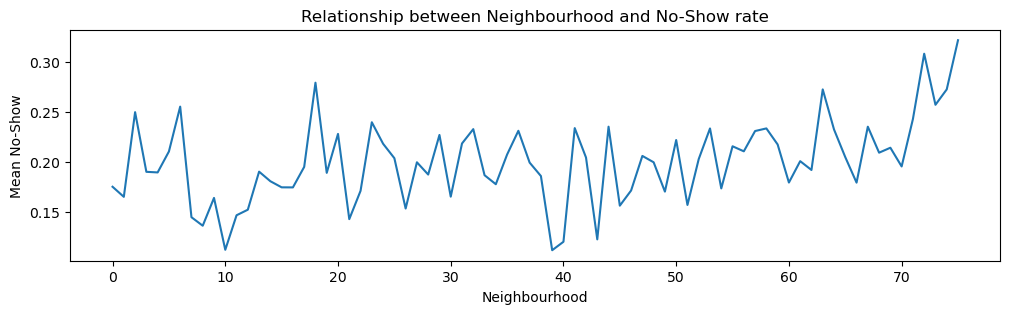

In [75]:
fig = plt.figure()
fig = y_test.groupby(X_test_2_enco["Neighbourhood"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("Neighbourhood"))
fig.set_ylabel("Mean No-Show")
plt.show()

#### No es de extrañar que la codificacion ordinal ordenada tenga un comportamiento similar o incluso peor que la codificación media suavizada

#### Se realizaran tres alternativas:
 1. Neighbourhood se codificará con la media suavizada
 2. Transformar la caracteristica Neighbourhood en dummies, lo cual aumentará el costo computacional de los modelos
 3. Se eliminará la caracteristica Neighbourhood

Luego se comparará el desempeño obtenido en cada modelo con cada conjunto alternativo.

Para el pipeline
1. Codificación de Neighbourhood usando la media suavizada
('mean_encoder', MeanEncoder(variables=["Neighbourhood"]))

2. Codificación a dummies (one-hot encoding)
('one_hot_encoder', OneHotEncoder(variables=['Neighbourhood'], drop_last=True))
Como anteriormente nos aseguramos que no pueden haber barrios con una frecuencia absoluta menor a 100 utilizamos fe_OneHotEncoder que importamos de feature engine en lugar de Sklearn

3. Eliminación de la característica Neighbourhood
('drop_features', DropFeatures(features_to_drop=['Neighbourhood']))

#### - **ScheduledDay**: Fecha y hora en que se programó la cita.
#### - **AppointmentDay**: Fecha de la cita.

In [80]:
# Función para convertir a datetime
def convert_to_datetime(X, column_names):
    for column in column_names:
        if column in X.columns:  # Verificar si la columna existe
            X[column] = pd.to_datetime(X[column])
        else:
            print(f"Columna {column} no encontrada en el DataFrame.")
    return X

In [81]:
# Convertir AppointmentDay a datetime
X_train_to_date = convert_to_datetime(X_train_rare_label, ['AppointmentDay', 'ScheduledDay'])
X_test_to_date = convert_to_datetime(X_test_rare_label, ['AppointmentDay', 'ScheduledDay'])

In [82]:
# Para el pipeline
#('datetime_converter', FunctionTransformer(lambda X: convert_to_datetime(X, ['AppointmentDay', 'ScheduledDay']), validate=False)),

In [83]:
X_train_to_date[['AppointmentDay', 'ScheduledDay']].dtypes

AppointmentDay    datetime64[ns, UTC]
ScheduledDay      datetime64[ns, UTC]
dtype: object

In [84]:
X_train_to_date.head(4)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
3635,9.673194e+14,F,2016-03-29 16:09:39+00:00,2016-05-03 00:00:00+00:00,37,RESISTÊNCIA,0,0,0,0,0,1
274,3.995366e+12,F,2016-04-29 12:16:28+00:00,2016-04-29 00:00:00+00:00,41,MARIA ORTIZ,0,0,0,0,0,0
48969,7.988999e+14,F,2016-05-12 09:48:29+00:00,2016-05-17 00:00:00+00:00,68,JARDIM DA PENHA,0,1,0,0,0,0
76571,6.267396e+14,M,2016-05-13 15:56:43+00:00,2016-05-13 00:00:00+00:00,13,ANDORINHAS,1,0,0,0,0,0


In [85]:
X_train_to_date['Hour'] = X_train_to_date['AppointmentDay'].dt.hour
X_train_to_date['DayOfWeek'] = X_train_to_date['AppointmentDay'].dt.day_name()
X_train_to_date['DayOfMonth'] = X_train_to_date['AppointmentDay'].dt.day
X_train_to_date['Month'] = X_train_to_date['AppointmentDay'].dt.month
X_train_to_date['WaitingTime'] = (X_train_to_date['AppointmentDay'] - X_train_to_date['ScheduledDay']).dt.days

X_test_to_date['Hour'] = X_test_to_date['AppointmentDay'].dt.hour
X_test_to_date['DayOfWeek'] = X_test_to_date['AppointmentDay'].dt.day_name()
X_test_to_date['DayOfMonth'] = X_test_to_date['AppointmentDay'].dt.day
X_test_to_date['Month'] = X_test_to_date['AppointmentDay'].dt.month
X_test_to_date['WaitingTime'] = (X_test_to_date['AppointmentDay'] - X_test_to_date['ScheduledDay']).dt.days

<Axes: >

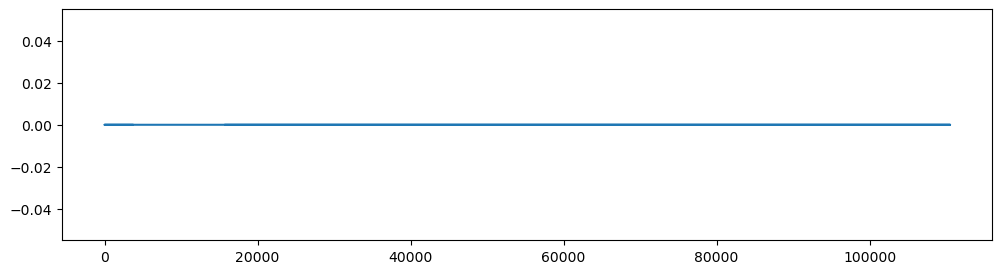

In [86]:
# Como se saca turno pero no para una hora en particular no agregar una caracteristica con la hora del turno no agrega valor
X_train_to_date['Hour'].plot(kind='line')

In [87]:
train_set = pd.concat([X_train_to_date, y_train], axis = 1)

In [88]:
train_set.head(2)

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Hour,DayOfWeek,DayOfMonth,Month,WaitingTime,No-show
3635,9.673194e+14,F,2016-03-29 16:09:39+00:00,2016-05-03 00:00:00+00:00,37,RESISTÊNCIA,0,0,0,0,0,1,0,Tuesday,3,5,34,0
274,3.995366e+12,F,2016-04-29 12:16:28+00:00,2016-04-29 00:00:00+00:00,41,MARIA ORTIZ,0,0,0,0,0,0,0,Friday,29,4,-1,0


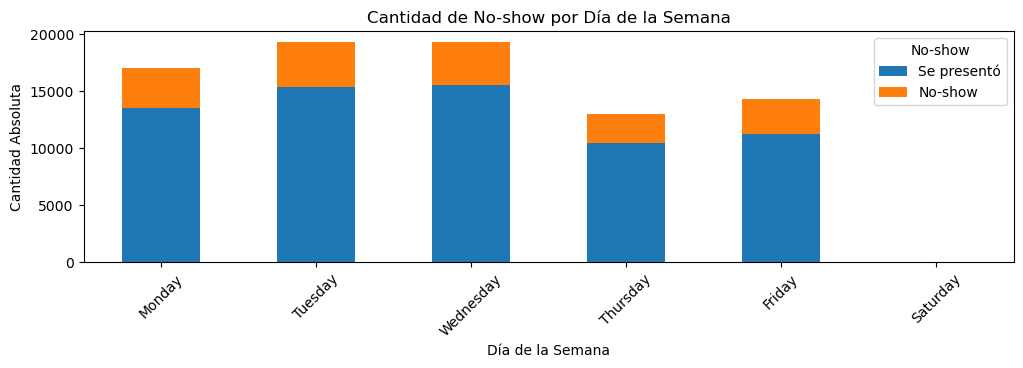

In [89]:
# Definir el orden de los días de la semana
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Convertir 'DayOfWeek' a tipo categórico con el orden especificado
train_set['DayOfWeek'] = pd.Categorical(train_set['DayOfWeek'], categories=day_order, ordered=True)

# Creamos la tabla de contingencia
contingency_table = pd.crosstab(train_set['DayOfWeek'], train_set['No-show'])

# Graficamos la tabla de contingencia
contingency_table.plot(kind='bar', stacked=True)
plt.title('Cantidad de No-show por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad Absoluta')
plt.xticks(rotation=45)
plt.legend(title='No-show', labels=['Se presentó', 'No-show'])
plt.show()

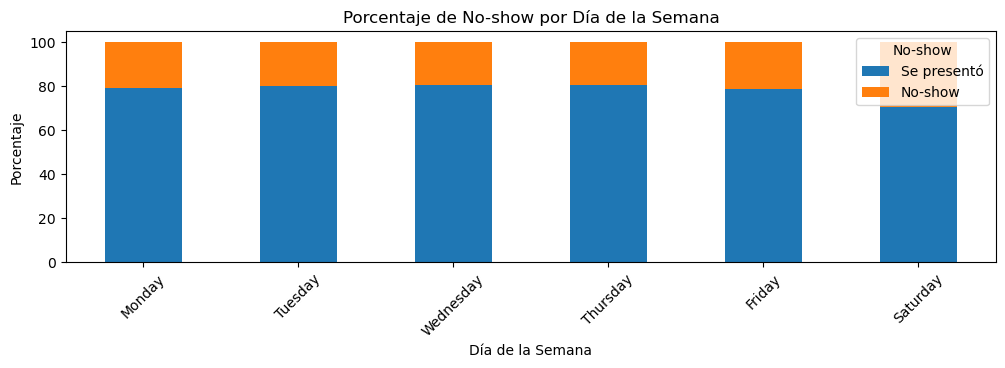

In [90]:
# Calculamos los porcentajes
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Graficamos
contingency_table_percentage.plot(kind='bar', stacked=True)
plt.title('Porcentaje de No-show por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Porcentaje')
plt.xticks(rotation=45)
plt.legend(title='No-show', labels=['Se presentó', 'No-show'])
plt.show()

#### Si bien, hay días de la semana que tienen mayor o menor cantidad de turnos, el porcentaje de inasistencia no pareciera verse afectado por el día.

In [92]:
contingency_table_percentage

No-show,0,1
DayOfWeek,,
Monday,79.076183,20.923817
Tuesday,79.910668,20.089332
Wednesday,80.546199,19.453801
Thursday,80.532472,19.467528
Friday,78.605433,21.394567
Saturday,70.370370,29.629630


In [93]:
contingency_table 

No-show,0,1
DayOfWeek,,
Monday,13473,3565
Tuesday,15386,3868
Wednesday,15543,3754
Thursday,10466,2530
Friday,11228,3056
Saturday,19,8


In [94]:
# Realizar la prueba de Chi-cuadrado
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Imprimir los resultados
print(f"Chi2 Stat: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")

Chi2 Stat: 30.663146461027893
P-Value: 1.0916590945474506e-05
Degrees of Freedom: 5


In [95]:
# Como P-Value: 0.00016 hay evidencia suficiente para afirmar que las proporciones de inasistencia no son iguales entre los días de la semana.

In [96]:
# Filtrar para omitir el sábado
filtered_data = train_set[train_set['DayOfWeek'] != 'Saturday']

# Crear la tabla de contingencia
contingency_table = pd.crosstab(filtered_data['DayOfWeek'], filtered_data['No-show'])

# Realizar la prueba de Chi-cuadrado
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Imprimir los resultados
print(f"Chi2 Stat: {chi2_stat}")
print(f"P-Value: {p_value}")
print(f"Degrees of Freedom: {dof}")

Chi2 Stat: 29.192654793485524
P-Value: 7.14361266925486e-06
Degrees of Freedom: 4


In [97]:
# Tampoco podemos afirmar que las proporciones de ausencias son igual entre los dias de semana

#### El dia de la semana puede tener poder predictivo, ademas es conveniente agregar una columna que indique si es fin de semana o no

In [99]:
mean_enc_week_day = MeanEncoder(variables=["DayOfWeek"])
mean_enc_week_day.fit(X_train_to_date, y_train)

MeanEncoder(variables=['DayOfWeek'])

In [100]:
X_train_to_date2 = mean_enc_week_day.transform(X_train_to_date)
X_test_to_date2 = mean_enc_week_day.transform(X_test_to_date)

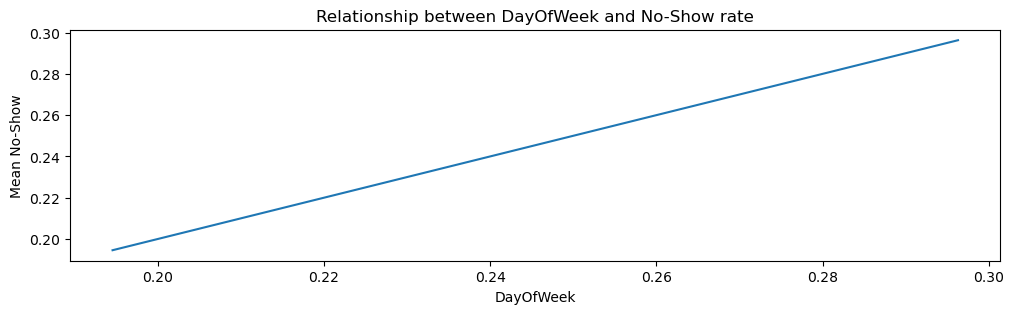

In [101]:
fig = plt.figure()
fig = y_train.groupby(X_train_to_date2["DayOfWeek"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("DayOfWeek"))
fig.set_ylabel("Mean No-Show")
plt.show()

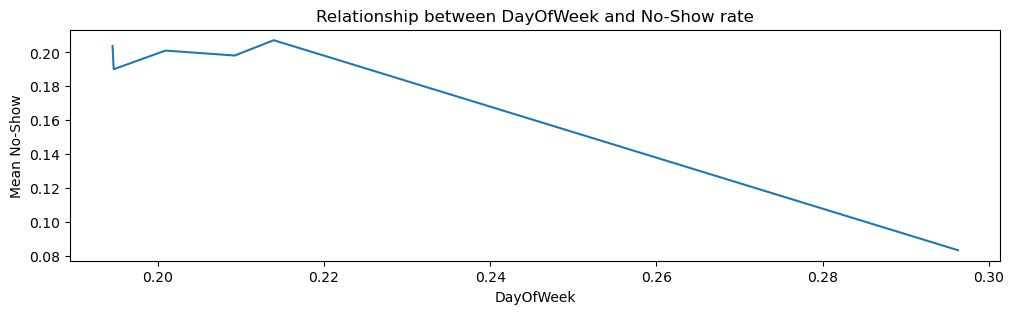

In [102]:
fig = plt.figure()
fig = y_test.groupby(X_test_to_date2["DayOfWeek"]).mean().plot()
fig.set_title("Relationship between {} and No-Show rate".format("DayOfWeek"))
fig.set_ylabel("Mean No-Show")
plt.show()

#### Los pacientes en el conjunto de datos de entrenamiento tienen un comportamiento opuesto a los pacientes del conjunto de prueba. Por este motivo se con el día de la semana se harán caracteristicas dummies, por lo que no sería necesario hacer una caracteristica que indique si es fin de semana o no.

# Los conjuntos de datos estan sesgados segun el comportamiento de los clientes que los componen. 
## En el proyecto ... en lugar de separa por clientes se hace una separación aleatoria de para eliminar, o en el peor de los casos mitigar, este sesgo